# **Dataset context**

The Garbage Classification dataset was created to support the development of machine learning models for automated waste sorting and recycling systems. It consists of labeled images of various types of garbage, such as cardboard, glass, metal, paper, plastic and general trash. The goal is to train models to recognize and classify these waste types based on visual characteristics.

This dataset is particularly useful for computer vision applications in environmental sustainability, where automatic identification of recyclable materials can aid in improving waste management efficiency, reducing human error and supporting smart bin technologies. Its real-world variability—such as different lighting, angles, and backgrounds—makes it suitable for building robust image classification systems.

# **Dataset content**

* **Total Classes**: 6 categories of garbage:

 - 1. cardboard

 - 2. glass

 - 3. metal

 - 4. paper

 - 5. plastic

 - 6. trash

* **File Format**: Images are stored as .jpg files. Typical image dimensions vary (e.g., ~384x512 pixels), but can be resized for modeling.

* **Labeling**: Each folder name serves as the class label for the images it contains.

* **Number of Images**: ~2,500–2,600 total images (approx. 400–500 per class).

* **Image Variety**: Photos include various object shapes, sizes, and backgrounds to mimic real-world conditions. Some images show used/dirty items, others are clean, making it suitable for generalization.

*(source: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification/data)*

# **Imports**

In [ ]:
!pip install -r requirements.txt --quiet

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import tqdm
import random
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import transform
from sklearn.model_selection import train_test_split
import zipfile
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.layer_utils import count_params
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import tensorflow as tf
from keras import regularizers

from joblib import dump, load

warnings.filterwarnings('ignore')

import os
from IPython.display import display
import ipywidgets as widgets
import zipfile
import time
from typing import Dict

# **Functions**

In [46]:
def handle_upload(change: dict) -> None:
    """
    Handles the upload event for Kaggle JSON credential file.
    """
    if uploader.value:
        for fname, file in uploader.value.items():
            # Save the file temporarily
            with open("kaggle.json", "wb") as f:
                f.write(file["content"])
                print("kaggle.json saved locally.")
                
        # Create the .kaggle directory if it doesn't exist
        kaggle_dir = os.path.expanduser("~/.kaggle")
        os.makedirs(kaggle_dir, exist_ok=True)
        # Move the file to ~/.kaggle
        os.replace("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))
        print("kaggle.json moved to ~/.kaggle")

In [61]:
def load_and_inspect_dataset(set_path: str, label_map: Dict[int, str])-> pd.DataFrame:
    """
    Loads training data from a CSV file, inspects its structure, maps numeric labels to class names,
    and prints summary information.
    """
    # Read the train data
    df = pd.read_csv(set_path, header=None, names=['picture', 'label'], delimiter=" ")

    # Display top 5 rows
    print("First 5 rows of the dataset:")
    print(df.head())

    # Check for missing values
    print("\n\nMissing values in each column:")
    print(df.isnull().sum())

    # Map label integers to class names
    df['label_name'] = df['label'].map(label_map)

    # Display dataset size
    print(f"\n\nTotal number of training examples: {len(df)}")

    # Show class distribution
    print("\n\nLabel distribution:")
    print(df['label'].value_counts())

    # Show info about DataFrame
    print("\n\nDataFrame info:")
    df.info()

    return df

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_label_distribution(df: pd.DataFrame) -> None:
    """
    Generates and displays a count plot for label distribution in the given DataFrame.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='label_name', order=df['label_name'].value_counts().index)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Label Distribution in train_df')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [66]:
import os
from typing import Union
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def display_sample_images(df: pd.DataFrame, data_dir: Union[str, os.PathLike]) -> None:
    """
    Displays one sample image per class from the training dataset with class labels.
    """
    classes = train_df['label_name'].unique()
    for label in classes:
        # Get the first sample image for the label
        sample = train_df[df['label_name'] == label].iloc[0]
        img_path = os.path.join(data_dir, sample['label_name'], str(sample['picture']))
        
        try:
            img = Image.open(img_path)
            plt.figure()
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis('off')
            plt.show()
        except FileNotFoundError:
            print(f"Image file not found: {img_path}")

# **Data preparation and downloading**

In [47]:
# Upload kaggle.json
uploader = widgets.FileUpload(accept='.json', multiple=False)
display(uploader)

FileUpload(value={}, accept='.json', description='Upload')

In [48]:
# Attach the handler to the uploader
uploader.observe(handle_upload, names='value')

In [5]:
# Download dataset
!kaggle datasets download -d asdasdasasdas/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Unzip the data
with zipfile.ZipFile("garbage-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("garbage_dataset")

In [7]:
# The data consists of 5 text files
for root, dirs, files in os.walk("garbage_dataset"):
    print(f"Directory: {root}")
    print(f"Files: {files[:5]}")
    break

Directory: garbage_dataset
Files: ['one-indexed-files-notrash_test.txt', 'one-indexed-files-notrash_train.txt', 'one-indexed-files-notrash_val.txt', 'one-indexed-files.txt', 'zero-indexed-files.txt']


# EDA

In [53]:
# There are 6 labels of garbage: cardboard, glass, metal, paper, plastic and trash
data_dir  = './garbage_dataset/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [54]:
# Define train, test and val sets paths
train_dir = './garbage_dataset/one-indexed-files-notrash_train.txt'
test_dir = './garbage_dataset/one-indexed-files-notrash_test.txt'
val_dir = './garbage_dataset/one-indexed-files-notrash_val.txt'

In [55]:
# Map the labels of data to put them on the plots
label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}

## **Train set**

In [62]:
# There are no missing values
# Total number of examples for train set is 1768
train_df = load_and_inspect_dataset(train_dir, label_map)

First 5 rows of the dataset:
            picture  label
0  cardboard202.jpg      3
1      paper472.jpg      2
2      paper522.jpg      2
3      glass189.jpg      1
4      glass325.jpg      1


Missing values in each column:
picture    0
label      0
dtype: int64


Total number of training examples: 1768


Label distribution:
2    403
1    354
4    347
3    287
5    286
6     91
Name: label, dtype: int64


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   picture     1768 non-null   object
 1   label       1768 non-null   int64 
 2   label_name  1768 non-null   object
dtypes: int64(1), object(2)
memory usage: 41.6+ KB


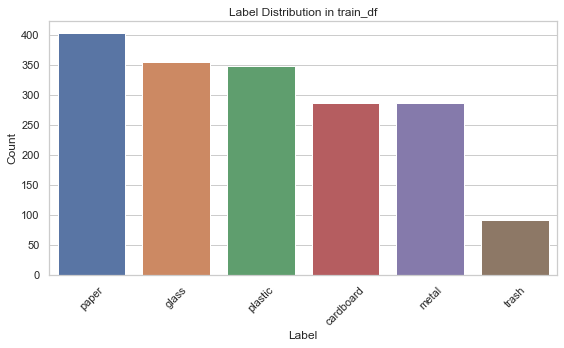

In [64]:
# There are the most glass examples (403) and the least trash examples (91)
plot_label_distribution(train_df)

In [67]:
# Display sample images and their distribution per class for train set
display_sample_images(train_df, train_dir)

Image file not found: ./garbage_dataset/one-indexed-files-notrash_train.txt\cardboard\cardboard202.jpg
Image file not found: ./garbage_dataset/one-indexed-files-notrash_train.txt\paper\paper472.jpg
Image file not found: ./garbage_dataset/one-indexed-files-notrash_train.txt\glass\glass189.jpg
Image file not found: ./garbage_dataset/one-indexed-files-notrash_train.txt\metal\metal63.jpg
Image file not found: ./garbage_dataset/one-indexed-files-notrash_train.txt\trash\trash50.jpg
Image file not found: ./garbage_dataset/one-indexed-files-notrash_train.txt\plastic\plastic262.jpg


## **Test set**

In [19]:
test_df = pd.read_csv(test_dir, header=None, names=['picture', 'label'], delimiter = " ")
test_df.head()

,picture,label
0,paper70.jpg,2
1,paper380.jpg,2
2,cardboard31.jpg,3
3,glass12.jpg,1
4,paper169.jpg,2


In [20]:
# Check for missing values
print(test_df.isnull().sum())

picture    0
label      0
dtype: int64


In [21]:
test_df['label_name'] = test_df['label'].map(label_map)

In [22]:
# There are 431 photos in test set
print(len(test_df))

431


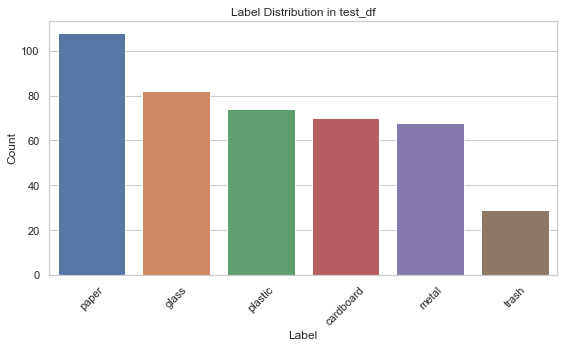

In [23]:
sns.set(style="whitegrid")

# Create the countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=test_df, x='label_name', order=test_df['label_name'].value_counts().index)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in test_df')
plt.xticks(rotation=45)  # Optional: rotate x-axis labels if needed

plt.tight_layout()
plt.show()

In [24]:
# In test set, there are the most glass examples (108) and the least trash examples (29) 
test_df['label'].value_counts()

2    108
1     82
4     74
3     70
5     68
6     29
Name: label, dtype: int64

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   picture     431 non-null    object
 1   label       431 non-null    int64 
 2   label_name  431 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.2+ KB


       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


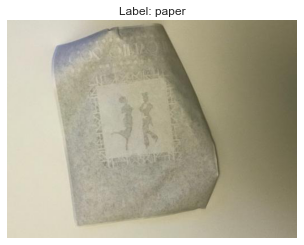

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


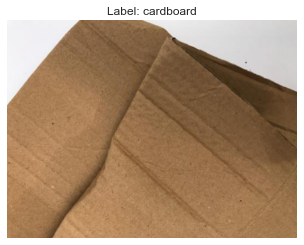

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


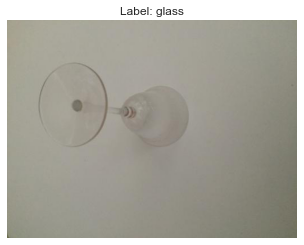

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


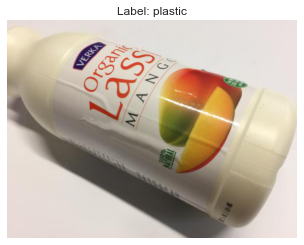

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


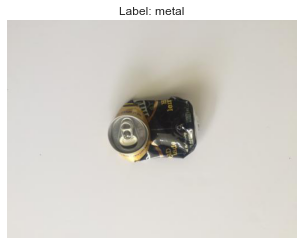

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


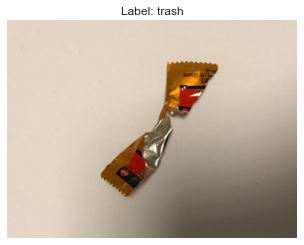

In [26]:
# Display sample images ant their distributions per class for test set
classes = test_df['label_name'].unique()

for label in classes:
    sample = test_df[test_df['label_name'] == label].iloc[0]
    img_path = str(data_dir)+'/'+sample['label_name']+"/"+str(sample['picture'])
    dimensions = []
    img = Image.open(img_path)
    dimensions.append(img.size)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    
    dim_df = pd.DataFrame(dimensions, columns=['width', 'height'])
    print(dim_df.describe())
    plt.show()

## **Validation set**

In [27]:
val_df = pd.read_csv(val_dir, header=None, names=['picture', 'label'], delimiter = " ")
val_df.head()

,picture,label
0,cardboard114.jpg,3
1,plastic204.jpg,4
2,glass123.jpg,1
3,glass152.jpg,1
4,glass398.jpg,1


In [28]:
# Check for missing values
print(val_df.isnull().sum())

picture    0
label      0
dtype: int64


In [29]:
val_df['label_name'] = val_df['label'].map(label_map)

In [30]:
# There are 328 photos in validation set
print(len(val_df))

328


In [31]:
# In validation set, there are the most glass examples (83) and the least trash examples (17) 
val_df['label'].value_counts()

2    83
1    65
4    61
5    56
3    46
6    17
Name: label, dtype: int64

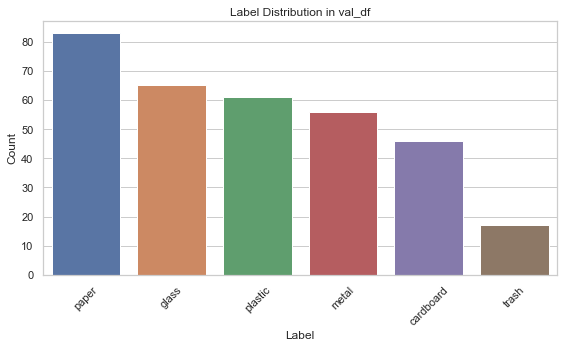

In [32]:
sns.set(style="whitegrid")

# Create the countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=val_df, x='label_name', order=val_df['label_name'].value_counts().index)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in val_df')
plt.xticks(rotation=45)  # Optional: rotate x-axis labels if needed

plt.tight_layout()
plt.show()

In [33]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   picture     328 non-null    object
 1   label       328 non-null    int64 
 2   label_name  328 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.8+ KB


       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


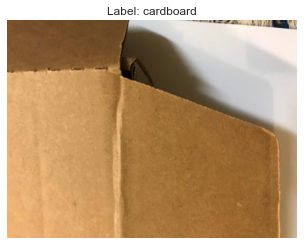

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


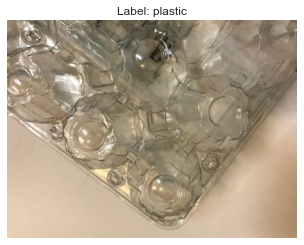

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


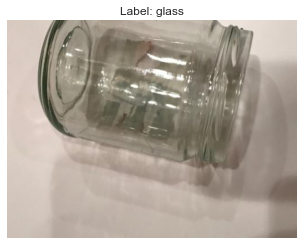

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


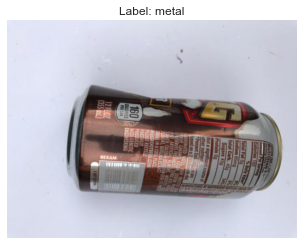

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


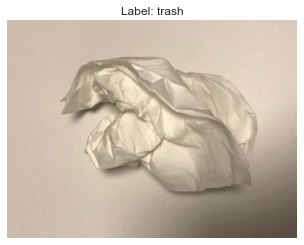

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


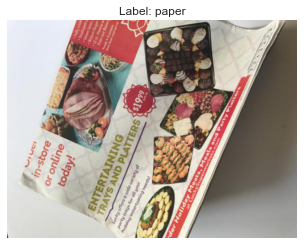

In [34]:
# Display sample images and their distributions per class for validation set
classes = val_df['label_name'].unique()

for label in classes:
    sample = val_df[val_df['label_name'] == label].iloc[0]
    img_path = str(data_dir)+'/'+sample['label_name']+"/"+str(sample['picture'])
    dimensions = []
    img = Image.open(img_path)
    dimensions.append(img.size)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    
    dim_df = pd.DataFrame(dimensions, columns=['width', 'height'])
    print(dim_df.describe())
    plt.show()

In [35]:
train_df.head()

,picture,label,label_name
0,cardboard202.jpg,3,cardboard
1,paper472.jpg,2,paper
2,paper522.jpg,2,paper
3,glass189.jpg,1,glass
4,glass325.jpg,1,glass


# Generators and iterators for each set

In [36]:
train_df['rel_path'] = train_df['label_name']+'/'+train_df['picture']
test_df['rel_path'] = test_df['label_name']+'/'+test_df['picture']
val_df['rel_path'] = val_df['label_name']+'/'+val_df['picture']

In [37]:
# Generators
train_generator = ImageDataGenerator(rescale = 1./255)

val_generator = ImageDataGenerator(rescale = 1./255)

test_generator = ImageDataGenerator(rescale = 1./255)

# Iterators
train_iterator = train_generator.flow_from_dataframe(train_df,
                                                     directory = data_dir,
                                                    x_col='rel_path',
                                                    y_col='label_name',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='categorical')

val_iterator = val_generator.flow_from_dataframe(val_df,
                                                 directory =  data_dir,
                                                    x_col='rel_path',
                                                    y_col='label_name',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='categorical')

test_iterator = test_generator.flow_from_dataframe(test_df,
                                                    directory = data_dir,
                                                    x_col='rel_path',
                                                    y_col='label_name',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='categorical')

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 431 validated image filenames belonging to 6 classes.


# Modelling - preparation

In [38]:
# Model evaluation function
def evaluate_model(trained_model):
  accuracy = trained_model.history.history['accuracy']
  val_accuracy = trained_model.history.history['val_accuracy']
  loss = trained_model.history.history['loss']
  val_loss = trained_model.history.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [39]:
# Gather results for each model
model_name = []
test_loss = []
test_acc = []
train_params = []
non_train_params = []

# Models

## Model 1

In [ ]:
# Architecture (CNN with MaxPooling)
model_I = Sequential()

model_I.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_I.add(MaxPooling2D(4, 4))

model_I.add(Conv2D(64, (3,3), activation='relu'))
model_I.add(MaxPooling2D(4, 4))

model_I.add(Conv2D(64, (3,3), activation='relu'))
model_I.add(MaxPooling2D(2, 2))

model_I.add(Flatten())
model_I.add(Dense(16, activation='relu'))
model_I.add(Dense(1, activation='softmax'))
model_I.summary()

In [ ]:
# Model compilation
model_I.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_I.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=32)

In [ ]:
evaluate_model(model_I)

In [ ]:
test_eval = model_I.evaluate(test_iterator, verbose=0)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

## Model 2 (dropout)

In [ ]:
# Architecture (CNN with MaxPooling and Dropout)
model_II = Sequential()

model_II.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_II.add(MaxPooling2D(4, 4))
model_II.add(Dropout(0.1))

model_II.add(Conv2D(64, (3,3), activation='relu'))
model_II.add(MaxPooling2D(4, 4))
model_II.add(Dropout(0.1))

model_II.add(Conv2D(64, (3,3), activation='relu'))
model_II.add(MaxPooling2D(2, 2))
model_II.add(Dropout(0.1))

model_II.add(Flatten())
model_II.add(Dense(16, activation='relu'))
model_II.add(Dense(1, activation='softmax'))
model_II.summary()

In [ ]:
# Model compilation
model_II.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_II = model_II.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

In [ ]:
evaluate_model(model_II)

In [ ]:
test_eval = model_II.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])   

## Model 3 (normalization)

In [ ]:

# Architecture (CNN with MaxPooling, Dropout and normalization)
model_III = Sequential()

model_III.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_III.add(MaxPooling2D(4, 4))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.1))

model_III.add(Conv2D(64, (3,3), activation='relu'))
model_III.add(MaxPooling2D(4, 4))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.1))

model_III.add(Conv2D(64, (3,3), activation='relu'))
model_III.add(MaxPooling2D(2, 2))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.1))

model_III.add(Flatten())
model_III.add(Dense(16, activation='relu'))
model_III.add(Dense(1, activation='softmax'))
model_III.summary()  

In [ ]:
# Model compilation
model_III.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_III = model_III.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

In [ ]:
evaluate_model(model_III)

In [ ]:
test_eval = model_III.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])    

## Model 4

In [ ]:
# Architecture (CNN with MaxPooling, Dropout, regularization, initialization and normalization)
model_IV = Sequential()

model_IV.add(Conv2D(32, (5,5), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer='glorot_uniform', activation='relu', input_shape=(128,128,3)))
model_IV.add(MaxPooling2D(4, 4))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.1))

model_IV.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer='glorot_uniform', activation='relu'))
model_IV.add(MaxPooling2D(4, 4))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.1))

model_IV.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer='glorot_uniform', activation='relu'))
model_IV.add(MaxPooling2D(2, 2))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.1))

model_IV.add(Flatten())
model_IV.add(Dense(16, activation='relu'))
model_IV.add(Dense(1, activation='softmax'))
model_IV.summary()

In [ ]:
# Model compilation
model_IV.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_IV = model_IV.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

In [ ]:
evaluate_model(model_IV)

In [ ]:
test_eval = model_IV.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])  

## New model

In [ ]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

In [ ]:
# Train the model
# history = model.fit(
#     train_iterator,
#     epochs=10,
#     validation_data=val_iterator, batch_size=128
# )

In [ ]:
# Evaluate the model

# Plot accuracy and loss
# plt.plot(history.history['accuracy'], label='train_acc')
# plt.plot(history.history['val_accuracy'], label='val_acc')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title("Model Accuracy")
# plt.show()

# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title("Model Loss")
# plt.show()

In [ ]:
# Confusionmatrix and classification report
# Predict on validation set
# from sklearn.metrics import classification_report, confusion_matrix
# val_iterator.reset()
# preds = model.predict(val_iterator)
# y_pred = np.argmax(preds, axis=1)
# y_true = val_iterator.classes
# class_labels = list(val_iterator.class_indices.keys())

# print("Classification Report:\n")
# print(classification_report(y_true, y_pred, target_names=class_labels))

# print("Confusion Matrix:\n")
# print(confusion_matrix(y_true, y_pred))

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
#     MaxPooling2D(2,2),
#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(2,2),
#     Conv2D(128, (3,3), activation='relu'),
#     MaxPooling2D(2,2),
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(6, activation='softmax')  # 6 classes
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# history_IV = model.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=128)

In [ ]:
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.optimizers import Adam

# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.3)(x)
# x = Dense(128, activation='relu')(x)
# predictions = Dense(6, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False  # Freeze base

# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history_IV = model.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=128)

In [ ]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
# x = Dense(128, activation='relu')(x)
# predictions = Dense(6, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history_IV = model.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=128)

In [40]:
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=128)

Epoch 1/5
4/4 [==============================] - 171s 50s/step - loss: 5.1890 - accuracy: 0.1883 - val_loss: 2.7239 - val_accuracy: 0.2713
Epoch 2/5
4/4 [==============================] - 95s 21s/step - loss: 2.2055 - accuracy: 0.2104 - val_loss: 1.7755 - val_accuracy: 0.1463
Epoch 3/5
4/4 [==============================] - 58s 13s/step - loss: 1.7685 - accuracy: 0.2285 - val_loss: 1.7376 - val_accuracy: 0.1890
Epoch 4/5
4/4 [==============================] - 52s 12s/step - loss: 1.7063 - accuracy: 0.2274 - val_loss: 1.6262 - val_accuracy: 0.3201
Epoch 5/5
4/4 [==============================] - 65s 15s/step - loss: 1.5526 - accuracy: 0.3705 - val_loss: 1.4638 - val_accuracy: 0.4329


In [41]:
model2 = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=128)

Epoch 1/5
4/4 [==============================] - 168s 41s/step - loss: 9.2957 - accuracy: 0.3066 - val_loss: 2.1747 - val_accuracy: 0.2530
Epoch 2/5
4/4 [==============================] - 167s 36s/step - loss: 4.4252 - accuracy: 0.4943 - val_loss: 2.6435 - val_accuracy: 0.2561
Epoch 3/5
4/4 [==============================] - 121s 25s/step - loss: 2.2400 - accuracy: 0.5385 - val_loss: 2.0737 - val_accuracy: 0.2043
Epoch 4/5
4/4 [==============================] - 109s 32s/step - loss: 1.4306 - accuracy: 0.6012 - val_loss: 2.2081 - val_accuracy: 0.2744
Epoch 5/5
4/4 [==============================] - 184s 50s/step - loss: 1.2030 - accuracy: 0.6499 - val_loss: 2.5780 - val_accuracy: 0.2409


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = False

model3 = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=128)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = True  # fine-tune entire model

model4 = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=128)